In [1]:
# General
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    make_scorer,
    recall_score,
)

# Model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")

In [2]:
bmt_train = pd.read_csv("train.csv", sep=";")
bmt_test = pd.read_csv("test.csv", sep=";")
bmt_train.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [3]:
bmt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
bmt_train.describe()

age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

In [5]:
cols_to_category = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]
bmt_train[cols_to_category] = bmt_train[cols_to_category].astype("category")

In [6]:
bmt_train["y"] = np.where(bmt_train["y"] == "no", 0, 1)
bmt_test["y"] = np.where(bmt_test["y"] == "no", 0, 1)

In [7]:
def counts_plot(y_var, col="w", ax=None):
    y_var_counts = (
        bmt_train.loc[:, y_var]
        .value_counts()
        .reset_index()
        .rename(columns={"index": y_var, y_var: "counts"})
        .assign(
            percent=lambda df_: (df_["counts"] / df_["counts"].sum()).round(2) * 100
        )
    )
    sns.set_context("paper")
    ax0 = sns.barplot(
        data=y_var_counts,
        x="percent",
        y=y_var,
        color=col,
        ax=ax,
        order=y_var_counts[y_var],
    )
    values1 = ax0.containers[0].datavalues
    labels = ["{:g}%".format(val) for val in values1]
    ax0.bar_label(ax0.containers[0], labels=labels, fontsize=9, color="#740405")
    ax0.set_ylabel("")
    ax0.set_xlabel("Percent", fontsize=10)
    ax0.set_title(str.title(y_var) + " | proportions ", fontsize=10)
    return

In [8]:
(
    bmt_train.loc[:, "y"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "y", "y": "counts"})
    .assign(percent=lambda df_: (df_["counts"] / df_["counts"].sum()).round(2) * 100)
)

counts  count  percent
0       0  39922      0.0
1       1   5289    100.0

In [9]:
def num_distributions(var_1, var_2):

    age_dur = bmt_train[[var_1, var_2, "y"]]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ## HistPlot

    sns.histplot(
        data=age_dur,
        kde=True,
        line_kws={"lw": 1.5, "alpha": 0.6},
        x=var_1,
        bins=20,
        hue="y",
        palette=target_color,
        alpha=0.6,
        ax=ax1,
    )
    ax1.legend(
        title="Subscribed?",
        loc="upper right",
        labels=["YES", "NO"],
        ncol=2,
        frameon=True,
        shadow=True,
        title_fontsize=8,
        prop={"size": 7},
        bbox_to_anchor=(1.18, 1.25),
    )
    ax1.set_xlabel(str.title(var_1), fontsize=10)
    ax1.set_ylabel("Frequency", fontsize=10)
    ax1.set_title(str.title(var_1) + " distributions", fontsize=12)
    ax1.yaxis.set_major_formatter(ticker.EngFormatter())

    ## Ccatter plot

    sns.scatterplot(
        data=age_dur,
        x=var_1,
        y=var_2,
        hue="y",
        ax=ax2,
        palette=target_color,
        legend=False,
        alpha=0.6,
    )
    ax2.yaxis.set_major_formatter(ticker.EngFormatter())
    ax2.set_title(str.title(var_2) + " distributions", fontsize=12)
    ax2.set_ylabel(str.title(var_2), fontsize=10)
    ax2.set_xlabel(str.title(var_1), fontsize=10)

    return

<h2 style= "font-weight: bold; color:#000000;">5.3.2.4 Balance and Duration</h2>

In [10]:
larg_dur = bmt_train["duration"].nlargest(10)
small_dur = bmt_train["duration"].nsmallest(5)
bmt_train.query("duration in @larg_dur | duration in @small_dur").sort_values(
    by="duration", ascending=False
).style.background_gradient()

<p style= "font-family:Calibri Sans Typewriter; color:#46555b; font-size:17px">OK! We don't know for certain what kind of call Subject takes about 5000 Sec (1.30 hours). it might be some data entry issue because we have some records with 0 sec. and 1 sec. duration using a cellular network! and it might be the sum of many call attempts, so we need more analysis to make a proper decision or even a correct assumption!</p>

In [11]:
(
    bmt_train[["default", "y"]]
    .value_counts()
    .reset_index()
    .rename(columns={0: "counts"})
    .style.background_gradient()
)

In [12]:
(
    bmt_train[["balance", "default", "y"]]
    .groupby(["default", "y"])["balance"]
    .agg(["mean", "count"])
    .reset_index()
    .style.background_gradient()
)

C:\Users\Suria Sarath\AppData\Local\Temp\ipykernel_23560\3797339862.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmt_train[["balance", "default", "y"]]


In [13]:
rf_seed = 345
np.random.seed(rf_seed)

In [14]:
train_x = bmt_train.iloc[:, :-1]
train_x.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  
0  unknown    5   may       261         1     -1         0  unknown  
1  unknown    5   may       151         1     -1         0  unknown  
2  unknown    5   may        76         1     -1         0  unknown  
3  unknown    5   may        92         1     -1         0  unknown  
4  unknown    5   may       198         1     -1         0  unknown

In [15]:
train_y = bmt_train[["y"]]

train_y = np.ravel(train_y)
train_y.shape

(45211,)

In [16]:
ohe_columns = list(train_x.select_dtypes(include="category").columns.values)
ohe_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [17]:
ohe_columns.remove("education")
ohe_columns

['job',
 'marital',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [18]:
train_x = pd.get_dummies(
    train_x, prefix=ohe_columns, columns=ohe_columns, drop_first=True
)
train_x.head()

age  education  balance  day  duration  campaign  pdays  previous  \
0   58   tertiary     2143    5       261         1     -1         0   
1   44  secondary       29    5       151         1     -1         0   
2   33  secondary        2    5        76         1     -1         0   
3   47    unknown     1506    5        92         1     -1         0   
4   33    unknown        1    5       198         1     -1         0   

   job_blue-collar  job_entrepreneur  ...  month_jul  month_jun  month_mar  \
0            False             False  ...      False      False      False   
1            False             False  ...      False      False      False   
2            False              True  ...      False      False      False   
3             True             False  ...      False      False      False   
4            False             False  ...      False      False      False   

   month_may  month_nov  month_oct  month_sep  poutcome_other  \
0       True      False      False      False           False   
1       True      False      False      False           False   
2       True      False      False      False           False   
3       True      False      False      False           False   
4       True      False      False      False           False   

   poutcome_success  poutcome_unknown  
0             False              True  
1             False              True  
2             False              True  
3             False              True  
4             False              True  

[5 rows x 40 columns]

In [19]:
recode_education_var = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
train_x["education"] = train_x["education"].replace(recode_education_var)
train_x["education"].value_counts(normalize=True)

C:\Users\Suria Sarath\AppData\Local\Temp\ipykernel_23560\1396258979.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_x["education"] = train_x["education"].replace(recode_education_var)
C:\Users\Suria Sarath\AppData\Local\Temp\ipykernel_23560\1396258979.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train_x["education"] = train_x["education"].replace(recode_education_var)


education
2    0.513194
3    0.294198
1    0.151534
0    0.041074
Name: proportion, dtype: float64

In [20]:
train_y.shape

(45211,)

In [21]:
test_x = bmt_test.iloc[:, :-1]
test_x.shape

(4521, 16)

In [22]:
test_y = bmt_test[["y"]]
test_y = np.ravel(test_y)
test_y.shape

(4521,)

In [23]:
test_x = pd.get_dummies(
    test_x, prefix=ohe_columns, columns=ohe_columns, drop_first=True
)
test_x.shape

(4521, 40)

In [24]:
test_x["education"] = test_x["education"].replace(recode_education_var)

C:\Users\Suria Sarath\AppData\Local\Temp\ipykernel_23560\61622226.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_x["education"] = test_x["education"].replace(recode_education_var)


In [25]:
test_x.shape

(4521, 40)

In [26]:
test_y.shape

(4521,)

In [27]:
rf = RandomForestClassifier(
    n_jobs=-1, random_state=rf_seed, class_weight="balanced_subsample"
)

In [28]:
# recall_score
rs = make_scorer(recall_score)

In [29]:
# CV
cv = cross_val_score(rf, train_x, train_y, cv=10, n_jobs=-1, scoring=rs)
print("Cross validation scores: {}".format(cv))
print("%0.2f recall with a standard deviation of %0.2f" % (cv.mean(), cv.std()))

Cross validation scores: [0.00378072 0.         0.01512287 0.05860113 0.03780718 0.08695652
 0.19848771 0.08506616 0.34215501 0.83742911]
0.17 recall with a standard deviation of 0.25


In [30]:
# Fit the model
rf.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=345)

In [31]:
pred = rf.predict(train_x)
print("The train recall score is {}".format(np.round(recall_score(train_y, pred), 4)))

The train recall score is 1.0


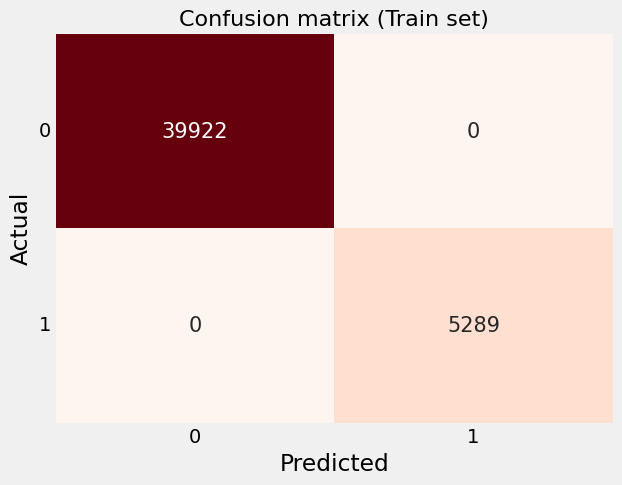

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39922
           1       1.00      1.00      1.00      5289

    accuracy                           1.00     45211
   macro avg       1.00      1.00      1.00     45211
weighted avg       1.00      1.00      1.00     45211



In [32]:
sns.heatmap(
    confusion_matrix(train_y, pred),
    annot=True,
    fmt="g",
    cbar=False,
    cmap="Reds",
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (Train set)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(train_y, pred))

In [33]:
pred = rf.predict(test_x)
print("The test recall score is {}".format(np.round(recall_score(test_y, pred), 4)))

The test recall score is 1.0


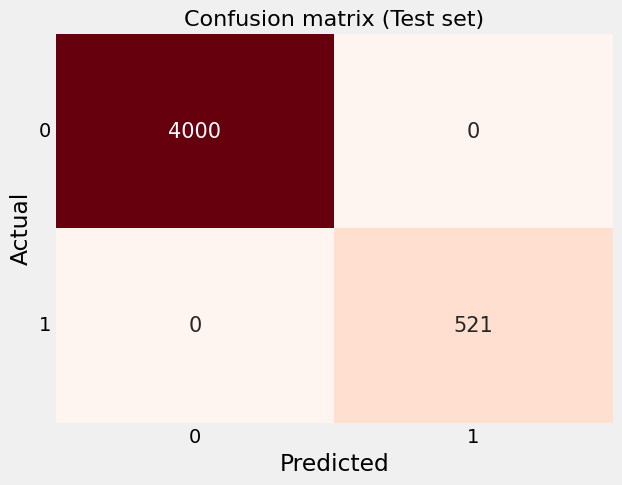

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00       521

    accuracy                           1.00      4521
   macro avg       1.00      1.00      1.00      4521
weighted avg       1.00      1.00      1.00      4521



In [34]:
sns.heatmap(
    confusion_matrix(test_y, pred),
    annot=True,
    fmt="g",
    cmap="Reds",
    cbar=False,
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (Test set)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(test_y, pred))

In [35]:
X = bmt_train.iloc[:, :-1]
X.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  
0  unknown    5   may       261         1     -1         0  unknown  
1  unknown    5   may       151         1     -1         0  unknown  
2  unknown    5   may        76         1     -1         0  unknown  
3  unknown    5   may        92         1     -1         0  unknown  
4  unknown    5   may       198         1     -1         0  unknown

In [36]:
y = bmt_train[["y"]]

y = np.ravel(train_y)
y.shape

(45211,)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify= y, random_state=rf_seed)

In [38]:
X_train.shape

(30291, 16)

In [39]:
y_train.shape

(30291,)

In [40]:
X_test.shape

(14920, 16)

In [41]:
y_test.shape

(14920,)

In [42]:
ohe_columns = list(X_train.select_dtypes(include="category").columns.values)
ohe_columns.remove("education")
ohe_columns

['job',
 'marital',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [43]:
X_train = pd.get_dummies(
    X_train, prefix=ohe_columns, columns=ohe_columns, drop_first=True
)
X_train.head()

age  education  balance  day  duration  campaign  pdays  previous  \
6086    38  secondary        0   27       166         2     -1         0   
27286   37   tertiary    11391   21       103         1     -1         0   
43029   35   tertiary      992   12      1416         1    170         4   
14148   45   tertiary     2220   11       128         2     -1         0   
35539   32   tertiary     2626    7       217         2    351         2   

       job_blue-collar  job_entrepreneur  ...  month_jul  month_jun  \
6086             False             False  ...      False      False   
27286            False             False  ...      False      False   
43029            False             False  ...      False      False   
14148            False             False  ...       True      False   
35539            False             False  ...      False      False   

       month_mar  month_may  month_nov  month_oct  month_sep  poutcome_other  \
6086       False       True      False      False      False           False   
27286      False      False       True      False      False           False   
43029      False      False      False      False      False           False   
14148      False      False      False      False      False           False   
35539      False       True      False      False      False            True   

       poutcome_success  poutcome_unknown  
6086              False              True  
27286             False              True  
43029             False             False  
14148             False              True  
35539             False             False  

[5 rows x 40 columns]

In [44]:
recode_education_var = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
X_train["education"] = X_train["education"].replace(recode_education_var)
X_train["education"].value_counts(normalize=True)

C:\Users\Suria Sarath\AppData\Local\Temp\ipykernel_23560\1264777765.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train["education"] = X_train["education"].replace(recode_education_var)
C:\Users\Suria Sarath\AppData\Local\Temp\ipykernel_23560\1264777765.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_train["education"] = X_train["education"].replace(recode_education_var)


education
2    0.514476
3    0.293024
1    0.152091
0    0.040408
Name: proportion, dtype: float64

In [45]:
y_train.shape

(30291,)

In [46]:
X_test = bmt_test.iloc[:, :-1]
X_test.shape

(4521, 16)

In [47]:
y_test = bmt_test[["y"]]
y_test = np.ravel(test_y)
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
X_test = pd.get_dummies(
    X_test, prefix=ohe_columns, columns=ohe_columns, drop_first=True
)
X_test.shape

(4521, 40)

In [49]:
X_test["education"] = test_x["education"].replace(recode_education_var)

In [50]:
X_test.shape

(4521, 40)

In [51]:
y_test.shape

(4521,)

Cross validation scores: [0.00378072 0.         0.01512287 0.05860113 0.03780718 0.08695652
 0.19848771 0.08506616 0.34215501 0.83742911]
0.17 recall with a standard deviation of 0.25
The train recall score is 1.0


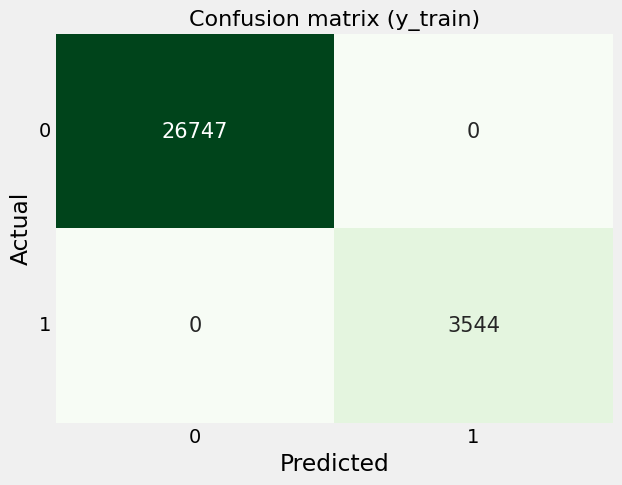

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26747
           1       1.00      1.00      1.00      3544

    accuracy                           1.00     30291
   macro avg       1.00      1.00      1.00     30291
weighted avg       1.00      1.00      1.00     30291

The test recall score is 0.75


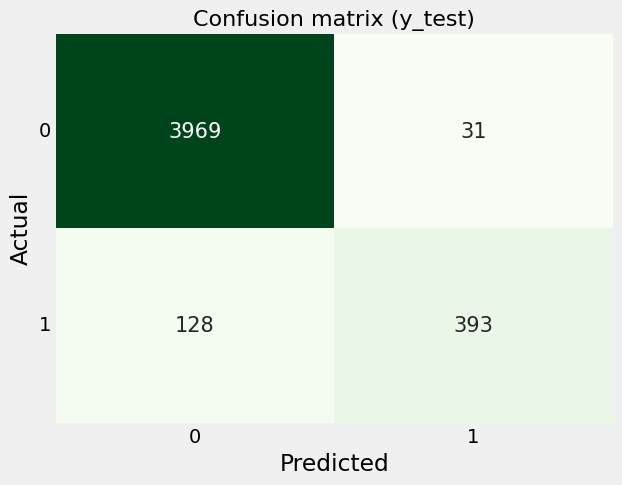

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4000
           1       0.93      0.75      0.83       521

    accuracy                           0.96      4521
   macro avg       0.95      0.87      0.91      4521
weighted avg       0.96      0.96      0.96      4521



In [52]:
rf2 = RandomForestClassifier(
    n_jobs=-1, random_state=rf_seed, class_weight="balanced_subsample"
)
# recall_score
rs2 = make_scorer(recall_score)

# CV
cv = cross_val_score(rf2, train_x, train_y, cv=10, n_jobs=-1, scoring=rs2)
print("Cross validation scores: {}".format(cv))
print("%0.2f recall with a standard deviation of %0.2f" % (cv.mean(), cv.std()))

# Fit the model
rf2.fit(X_train, y_train)

# Get predictions Train set
pred = rf2.predict(X_train)
print("The train recall score is {}".format(np.round(recall_score(y_train, pred), 2)))
#pred
#np.unique(pred)

sns.heatmap(
    confusion_matrix(y_train, pred),
    annot=True,
    fmt="g",
    cbar=False,
    cmap="Greens",
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (y_train)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_train, pred))


# Get predictions test set
pred = rf2.predict(X_test)
print("The test recall score is {}".format(np.round(recall_score(y_test, pred), 2)))

sns.heatmap(
    confusion_matrix(y_test, pred),
    annot=True,
    fmt="g",
    cmap="Greens",
    cbar=False,
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (y_test)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test, pred))

In [53]:
import pickle
with open("model.pkl","wb") as file:
    pickle.dump(rf2,file)
